In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from pathlib import Path

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import joblib

In [125]:
import importlib
import torch
import models
import train
import data
import utils
importlib.reload(models)
importlib.reload(train)
importlib.reload(data)
importlib.reload(utils)

from models import SedCNN, AttentionBlock, get_prediction
from train import run_training
from data import AudioDataset
from utils import plot_confusion_matrix

In [3]:
DATA_PATH = Path('/Volumes/DataSSD/SoundSegment/ESC-50-master/')
META_PATH = DATA_PATH / 'meta'
AUDIO_DATA = DATA_PATH / 'audio'

In [4]:
data = pd.read_csv(META_PATH / 'esc50.csv')
data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [5]:
needed_classes = ['dog', 'vacuum_cleaner', 'cat', 'pouring_water']

In [6]:
df = data[data.category.isin(needed_classes)]

In [7]:
df.sample(10)

,filename,fold,target,category,esc10,src_file,take
468,2-110010-A-5.wav,2,5,cat,False,110010,A
353,1-79220-A-17.wav,1,17,pouring_water,False,79220,A
1013,3-152020-B-36.wav,3,36,vacuum_cleaner,False,152020,B
1023,3-154439-A-17.wav,3,17,pouring_water,False,154439,A
572,2-141682-B-36.wav,2,36,vacuum_cleaner,False,141682,B
1014,3-152020-C-36.wav,3,36,vacuum_cleaner,False,152020,C
1373,4-172736-A-36.wav,4,36,vacuum_cleaner,False,172736,A
404,2-102414-B-17.wav,2,17,pouring_water,False,102414,B
831,3-108451-B-17.wav,3,17,pouring_water,False,108451,B
283,1-56380-B-5.wav,1,5,cat,False,56380,B


In [50]:
cls_map = dict([(0, 'dog'), (5, 'cat'), (17, 'pouring_water'), (36, 'vacuum_cleaner')])
cls_map

{0: 'dog', 5: 'cat', 17: 'pouring_water', 36: 'vacuum_cleaner'}

In [8]:
df.shape

(160, 7)

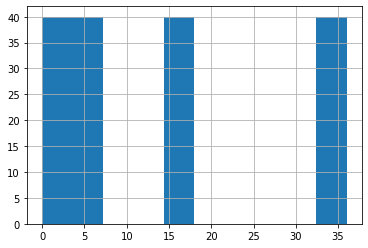

In [29]:
df.target.hist()

In [9]:
# fitting encoders
le = LabelEncoder()
le.fit(df.target)

ohe = OneHotEncoder(sparse=False)
ohe.fit(np.array(df['target']).reshape(-1,1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [10]:
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df.target)

In [11]:
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [12]:
train_dataset = AudioDataset(df_train, le, ohe, AUDIO_DATA)
test_dataset = AudioDataset(df_test, le, ohe, AUDIO_DATA)

In [13]:
train_dataset[0]

(tensor([-0.0033, -0.0045, -0.0028,  ...,  0.0000,  0.0000,  0.0000]),
 tensor(0),
 tensor([[1., 0., 0., 0.]], dtype=torch.float64))

In [14]:
train_loader = DataLoader(train_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [65]:
model = SedCNN(n_classes=df.target.nunique(), n_fft=2048, hop_length=512, n_mels=128)

Loaded pretrained weights for efficientnet-b3


In [66]:
class PannLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.bce = nn.BCELoss()
        
    def forward(self, input_clip, target):
        input_clip = torch.where(torch.isnan(input_clip), torch.zeros_like(input_clip), input_clip)
        
        input_clip = torch.where(torch.isinf(input_clip), torch.zeros_like(input_clip), input_clip)
        
        input_clip = torch.where(input_clip >= 1.0, torch.tensor(0.99), input_clip)
        
        target = target.float()
        
        return self.bce(input_clip, target)

In [67]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = PannLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.01)


In [70]:
# KFold cross validation

In [126]:
kfold = KFold(n_splits=4)
models = {}
f1_scores = {}
for fold, (train_indices, test_indices) in enumerate(kfold.split(df, y=df['target'])):
    print(f'========Starting fold {fold}==========')
    df_train = df.iloc[train_indices].reset_index()
    df_test = df.iloc[test_indices].reset_index()
    
    train_dataset = AudioDataset(df_train, le, ohe, AUDIO_DATA)
    test_dataset = AudioDataset(df_test, le, ohe, AUDIO_DATA)
    
    train_loader = DataLoader(train_dataset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)
    
    model = SedCNN(n_classes=df.target.nunique(), n_fft=512, hop_length=512, n_mels=128)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.01)
    
    f1_score = run_training(model, train_loader, test_loader, loss_fn, optimizer, scheduler=scheduler, early_stop_patience=5, EPOCHS=7)
    
    models[fold] = model
    f1_scores[fold] = f1_score
    

========Starting fold 0==========


training:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b3


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
Train Epoch loss 1.3079597055912018
Train f1 score 0.3587021026359261


eval: 100%|██████████| 3/3 [00:13<00:00,  4.41s/it]


Epoch 0
Eval Epoch loss 1.4344451030095418
Eval f1 score 0.3013888888888889


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
Train Epoch loss 1.2011255323886871
Train f1 score 0.5461423992673993


eval: 100%|██████████| 3/3 [00:12<00:00,  4.20s/it]


Epoch 1
Eval Epoch loss 1.4216972986857097
Eval f1 score 0.4061431623931624


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2
Train Epoch loss 1.2059472352266312
Train f1 score 0.49375311274982325


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2
Eval Epoch loss 1.4169617891311646
Eval f1 score 0.3813131313131313


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3
Train Epoch loss 1.2003439217805862
Train f1 score 0.5027201964701965


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3
Eval Epoch loss 1.4202165603637695
Eval f1 score 0.3913253413253413
Early stopping 0


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4
Train Epoch loss 1.1878696382045746
Train f1 score 0.556258671883672


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4
Eval Epoch loss 1.4245532353719075
Eval f1 score 0.3621586746586747
Early stopping 1


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5
Train Epoch loss 1.1958084553480148
Train f1 score 0.5347888222888223


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5
Eval Epoch loss 1.4280006090799968
Eval f1 score 0.3707371060312237
Early stopping 2


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6
Train Epoch loss 1.2015859633684158
Train f1 score 0.5332093253968254


eval: 100%|██████████| 3/3 [00:10<00:00,  3.62s/it]


Epoch 6
Eval Epoch loss 1.429683009783427
Eval f1 score 0.3472328325269502
Early stopping 3
========Starting fold 1==========


training:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b3


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
Train Epoch loss 1.3177124708890915
Train f1 score 0.3829347735597736


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 0
Eval Epoch loss 1.3669527371724446
Eval f1 score 0.22802197802197802


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
Train Epoch loss 1.2010701149702072
Train f1 score 0.6476148349092429


eval: 100%|██████████| 3/3 [00:12<00:00,  4.30s/it]


Epoch 1
Eval Epoch loss 1.3620094060897827
Eval f1 score 0.28911643911643914


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2
Train Epoch loss 1.1916047036647797
Train f1 score 0.6406317640692641


eval: 100%|██████████| 3/3 [00:12<00:00,  4.08s/it]


Epoch 2
Eval Epoch loss 1.3517625729242961
Eval f1 score 0.2930846930846931


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3
Train Epoch loss 1.1965120136737823
Train f1 score 0.6734754828504829


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3
Eval Epoch loss 1.3422083059946697
Eval f1 score 0.431580553948975


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4
Train Epoch loss 1.19145667552948
Train f1 score 0.6121201714951715


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4
Eval Epoch loss 1.3372140328089397
Eval f1 score 0.42017704517704507


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5
Train Epoch loss 1.1969682723283768
Train f1 score 0.6193374333999334


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5
Eval Epoch loss 1.3349930047988892
Eval f1 score 0.46048205607029136


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6
Train Epoch loss 1.1961650401353836
Train f1 score 0.6092374639249639


eval: 100%|██████████| 3/3 [00:10<00:00,  3.63s/it]


Epoch 6
Eval Epoch loss 1.3350147008895874
Eval f1 score 0.48897907647907646
Early stopping 0
========Starting fold 2==========


training:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b3


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
Train Epoch loss 1.2581200003623962
Train f1 score 0.547987776112776


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 0
Eval Epoch loss 1.3657892147699993
Eval f1 score 0.23171296296296295


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
Train Epoch loss 1.1269316673278809
Train f1 score 0.7917388167388167


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1
Eval Epoch loss 1.3706085681915283
Eval f1 score 0.262962962962963
Early stopping 0


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2
Train Epoch loss 1.1133768409490585
Train f1 score 0.8096681096681096


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2
Eval Epoch loss 1.364327351252238
Eval f1 score 0.31742141300964827


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3
Train Epoch loss 1.1157062947750092
Train f1 score 0.8112640831390832


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3
Eval Epoch loss 1.3571421305338542
Eval f1 score 0.40720899470899474


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4
Train Epoch loss 1.1208296120166779
Train f1 score 0.796084817959818


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4
Eval Epoch loss 1.3524638414382935
Eval f1 score 0.4021214896214897


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5
Train Epoch loss 1.1216492652893066
Train f1 score 0.8107767232767232


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5
Eval Epoch loss 1.3486863772074382
Eval f1 score 0.3907407407407408


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6
Train Epoch loss 1.1125887036323547
Train f1 score 0.8571282016594517


eval: 100%|██████████| 3/3 [00:10<00:00,  3.58s/it]


Epoch 6
Eval Epoch loss 1.3449965318044026
Eval f1 score 0.4060185185185185
========Starting fold 3==========


training:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b3


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
Train Epoch loss 1.2677356898784637
Train f1 score 0.4194688991563991


eval: 100%|██████████| 3/3 [00:12<00:00,  4.18s/it]


Epoch 0
Eval Epoch loss 1.3687466382980347
Eval f1 score 0.3466510341510342


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1
Train Epoch loss 1.1428089290857315
Train f1 score 0.7251120407370407


eval: 100%|██████████| 3/3 [00:12<00:00,  4.09s/it]


Epoch 1
Eval Epoch loss 1.3641453584035237
Eval f1 score 0.34854497354497355


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2
Train Epoch loss 1.1406311243772507
Train f1 score 0.7492172757797757


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2
Eval Epoch loss 1.3703365723292034
Eval f1 score 0.30609668109668114
Early stopping 0


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3
Train Epoch loss 1.1378551721572876
Train f1 score 0.7410140207015208


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3
Eval Epoch loss 1.37562890847524
Eval f1 score 0.28825156325156326
Early stopping 1


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4
Train Epoch loss 1.1558886170387268
Train f1 score 0.6915273962148962


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4
Eval Epoch loss 1.3790223598480225
Eval f1 score 0.18399470899470902
Early stopping 2


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5
Train Epoch loss 1.1357827186584473
Train f1 score 0.7283978174603174


training:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5
Eval Epoch loss 1.3811880747477214
Eval f1 score 0.18663003663003666
Early stopping 3


eval:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6
Train Epoch loss 1.1463444828987122
Train f1 score 0.7319038600288601


eval: 100%|██████████| 3/3 [00:11<00:00,  3.91s/it]

Epoch 6
Eval Epoch loss 1.382426102956136
Eval f1 score 0.20911680911680916
Early stopping 4
Early stopping stopped


In [129]:
# Mean f1 score
np.mean(list(f1_scores.values()))

0.41271905178155177

In [130]:
def predict_models(x):
    predictions = []
    for k, model in models.items():
        _, pred = model(x)
        predictions.append(pred.argmax(dim=1).detach().numpy()[0])
    return np.bincount(np.array(predictions)).argmax()
        

In [131]:
true_values = []
predicted_values = []
for x, yl, yo in DataLoader(test_dataset, batch_size=1):
    true_values.append(yl.detach().numpy()[0])
    predicted_values.append(predict_models(x))

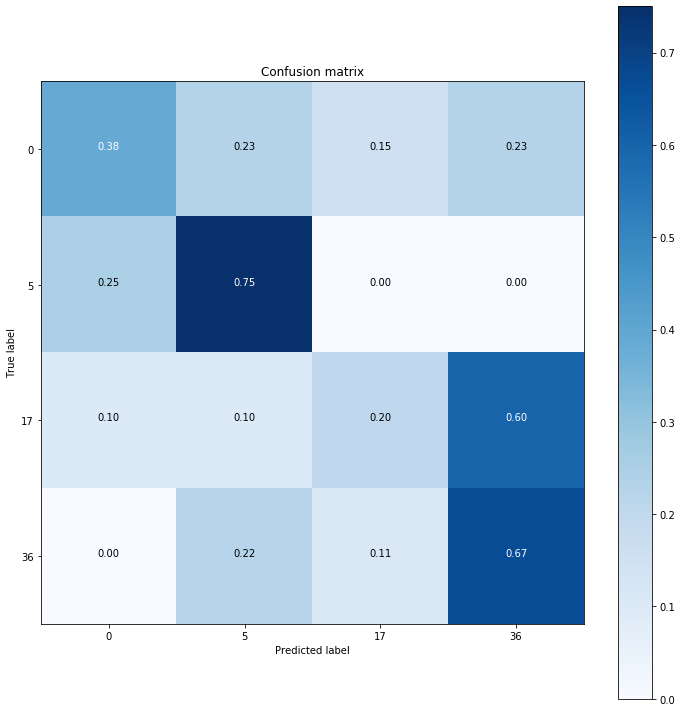

In [132]:
cm = confusion_matrix(true_values, predicted_values, normalize='true')
plot_confusion_matrix(cm, classes=le.classes_, normalize=True)

In [45]:
joblib.dump(le, 'label_encoder.pkl')

['label_encoder.pkl']

In [135]:

for fold, model in models.items():
    torch.save(model, f'trained_models/model_fold_{fold}.pth')